## Importations

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns
import boto3

## Configuration

In [2]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

In [3]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']))

## Utilitaires

In [4]:
def export_df(df, name):
    df.to_csv('output/{}_{}.csv'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d'), name), index=False, encoding='utf-8-sig')

In [5]:
def create_birthdate(user):
    if user['birthyear'] == user['birthyear']:
        try:
            return datetime.datetime(int(user['birthyear']), int(user['birthmonth']), int(user['birthday']))
        except Exception as e:
            if str(e) == 'day is out of range for month':
                user['birthday'] = 1
                return create_birthdate(user)
            else:
                print(str(e))
                return np.nan
            #if str(e) == 'day is out of range for month':
    else:
        return np.nan
        

def get_age(birthday):
    today = datetime.datetime.today()
    return int(today.year - birthday.year - ((today.month, today.day) < (birthday.month, birthday.day)))

def evaluate_row(row):
    acum = 0
    if row['age'] == row['age']:
        acum += 1
    if row['aprox_age'] == row['aprox_age']:
        acum += 1
    if row['age'] == row['aprox_age']:
        acum = acum*2
    return acum

def assign_not_null(row):
    age = np.nan
    if row['aprox_age'] == row['aprox_age']:
        age = row['aprox_age']    
    if row['age'] == row['age']:
        age = row['age']
    return age

def set_public(user):
    age = user['age']
    if age < 15:
        user['4-14'] = 1
    elif age < 25:
        user['15-24'] = 1
    elif age < 35:
        user['25-39'] = 1
    else:
        if age < 40:
            user['25-39'] = 1
        user['>35'] = 1
    return user

def set_age_range(age):
    bot = int('{}0'.format('{}'.format(int(age)+5).zfill(3)[0:2])) - 5
    if bot < 15:
        return '4-14'
    elif bot >= 65:
        return '65+'    
    top = bot + 9
    return '{}-{}'.format(bot, top)

# Attribution age par prénom

In [6]:
df = pd.read_csv('output/201112_definition_publics.csv')
df.head()

/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


uid    actitoid  birthday  birthmonth  \
0                               NaN  22265988.0       NaN         NaN   
1  f67291714b9c4cd5b821a178c9f9839c  34121208.0       1.0         1.0   
2  7aaacc7f21434fdb9719987fa9b36c0c  25829471.0       1.0         1.0   
3  06b7e458179c4483a1090764c53bc840  34121232.0       1.0         1.0   
4  07a1b91e682f4417b2b73ae800716f5a  34121254.0       1.0         1.0   

   birthyear birthdate_actito  aprox_age assignedfirstname  \
0        NaN              NaN        NaN         Catherine   
1        NaN              NaN        NaN          Lancelot   
2        NaN              NaN        NaN             Jenna   
3        NaN              NaN        NaN           Olivier   
4        NaN              NaN        NaN           Josette   

       birthdate_gigya   age  age_diff age_diff_g  
0  1958-06-12 00:00:00  62.0      -1.0         -1  
1                  NaN   NaN      -1.0         -1  
2                  NaN   NaN      -1.0         -1  
3  1974-12-31 00:00:00  45.0      -1.0         -1  
4                  NaN   NaN      -1.0         -1

In [12]:
df['actitoid'] = df['actitoid'].astype(int)

In [13]:
df = df[~df['age'].isna()]

In [14]:
df['age'] = df['age'].astype(int)

In [15]:
export_df(df[['actitoid','assignedfirstname','age']], 'fichier_validation')

# 201014: api.py

In [6]:
df_current = pd.read_csv('output/200918_egos_gigya_augmented.csv')
df_current.head()

uid  >35 age_range public  \
0  _guid_CS4vFSKzwMfBLvF9fXX9FW_MTdoQxoAvPwlF1oLa...  0.0       NaN    NaN   
1                   d9f727cc8f91444790ca9c4f318a9159  0.0       NaN    NaN   
2                   955927d6eb2d49ae8cad8e50c3c93652  0.0       NaN    NaN   
3                   9558daa7798745de9f493a873eeba947  0.0       NaN    NaN   
4                   95583e8b32984175bce3a0aee3c1c0e7  0.0       NaN    NaN   

  gender  
0    NaN  
1      m  
2      f  
3    NaN  
4      m

In [7]:
df_current.shape

(3569080, 5)

In [8]:
['{}%'.format(round(i/len(df_current)*100)) for i in df_current.count()]

['100%', '100%', '45%', '21%', '80%']

In [10]:
#df_gigya_genre = pd.read_csv('output/201013_uid_ass_gender.csv')
#df_gigya_genre.shape

In [12]:
#df_current = df_current.merge(df_gigya_genre[['assigned_gender','uid']], on='uid', how='left')
#df_current.head()

In [28]:
['{}%'.format(round(i/len(df_current)*100)) for i in df_current.count()]

['100%', '100%', '45%', '21%', '80%', '88%']

In [29]:
df_current['gender'] = df_current['assigned_gender']

In [30]:
del df_current['assigned_gender']

In [31]:
df_current.head()

uid  >35 age_range public  \
0  _guid_CS4vFSKzwMfBLvF9fXX9FW_MTdoQxoAvPwlF1oLa...  0.0       NaN    NaN   
1                   d9f727cc8f91444790ca9c4f318a9159  0.0       NaN    NaN   
2                   955927d6eb2d49ae8cad8e50c3c93652  0.0       NaN    NaN   
3                   9558daa7798745de9f493a873eeba947  0.0       NaN    NaN   
4                   95583e8b32984175bce3a0aee3c1c0e7  0.0       NaN    NaN   

  gender  
0      m  
1      m  
2      f  
3      m  
4      m

In [32]:
df_current.to_csv('output/201013_uid_ass_gender.csv', index=False, encoding='utf-8-sig')

## Données

### Actito

In [6]:
df_actito = pd.read_sql_query("""SELECT actitoid, email, firstname, assignedfirstname, lastname, birthdate FROM egos_actito WHERE assignedfirstname IS NOT NULL AND assignedfirstname <> ''""", engine)
df_actito.head()

actitoid                   email  firstname assignedfirstname   lastname  \
0  22265988    c.dedycker@skynet.be  Catherine         Catherine  De Dycker   
1  22472868       marc_ve@skynet.be       marc              Marc  VER EYKEN   
2  23746390       guissem@gmail.com  Guillaume         Guillaume     Bassem   
3  24791866         henhorne@voo.be      henri             Henri      horne   
4  24832111  roland.feron@gmail.com     Roland            Roland      Feron   

    birthdate  
0  12/06/1958  
1  19/01/1957  
2  04/02/1986  
3              
4

In [7]:
df_actito.shape

(3187897, 6)

In [8]:
df_actito.count()

actitoid             3187897
email                3187897
firstname            3187897
assignedfirstname    3187897
lastname             3187897
birthdate            3187897
dtype: int64

In [9]:
df_actito.isnull().any()

actitoid             False
email                False
firstname            False
assignedfirstname    False
lastname             False
birthdate            False
dtype: bool

### Gigya

In [10]:
df_gigya = pd.read_sql_query("""SELECT uid, email, actitoid, firstname, lastname, birthday, birthmonth, birthyear, age FROM egos_gigya""", engine)
df_gigya.head()

uid                           email  \
0  0000092334f74ac2af6bbf8ef2907ee1       olivier_balas@hotmail.com   
1  000103aedd48435b8d5fc381dbb4917e           Smetsfabien@gmail.com   
2  00010e5980b54ec5b81a190bd32ae48d            marcy-m92@hotmail.fr   
3  000198b89cbc4b338ce02c76d42fef92            diogopinto@gmail.com   
4  0001a5e24a5a444292def42478538c08  timothee.piedboeuf@hotmail.com   

     actitoid firstname   lastname  birthday  birthmonth  birthyear   age  
0  26397656.0   Olivier        Bls       8.0         5.0     1987.0  31.0  
1  25429373.0    Fabien     Fabien       NaN         NaN        NaN   NaN  
2  27182416.0     Marsi    Mampuya       NaN         NaN        NaN   NaN  
3  24749654.0     Diogo      Pinto       NaN         NaN        NaN   NaN  
4  26515777.0  Timothée  Piedboeuf       NaN         NaN        NaN   NaN

In [11]:
df_gigya.shape

(3723878, 9)

In [12]:
df_gigya.count()

uid           3723878
email         3723058
actitoid      3709863
firstname     3721995
lastname      3720126
birthday      1570294
birthmonth    1567469
birthyear     1582674
age           1582610
dtype: int64

In [13]:
df_gigya.isnull().any()

uid           False
email          True
actitoid       True
firstname      True
lastname       True
birthday       True
birthmonth     True
birthyear      True
age            True
dtype: bool

## Traitement

### Actito

In [14]:
df_actito['birthdate'] = df_actito['birthdate'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y') if x != '' else np.nan)
df_actito[~df_actito['birthdate'].isna()].head()

actitoid                       email  firstname assignedfirstname  \
0  22265988        c.dedycker@skynet.be  Catherine         Catherine   
1  22472868           marc_ve@skynet.be       marc              Marc   
2  23746390           guissem@gmail.com  Guillaume         Guillaume   
5  25138918  pavillonj@chu-charleroi.be      steve             Steve   
7  25822666      ameliekratz5@gmail.com     Amelie            Amelie   

    lastname            birthdate  
0  De Dycker  1958-06-12 00:00:00  
1  VER EYKEN  1957-01-19 00:00:00  
2     Bassem  1986-02-04 00:00:00  
5      gonze  1972-01-01 00:00:00  
7      Kratz  1987-02-13 00:00:00

In [15]:
df_actito.count()

actitoid             3187897
email                3187897
firstname            3187897
assignedfirstname    3187897
lastname             3187897
birthdate            1448352
dtype: int64

In [16]:
df_actito['age'] = df_actito['birthdate'].apply(lambda x: get_age(x) if x == x else np.nan)
df_actito[~df_actito['age'].isna()].head()

actitoid                       email  firstname assignedfirstname  \
0  22265988        c.dedycker@skynet.be  Catherine         Catherine   
1  22472868           marc_ve@skynet.be       marc              Marc   
2  23746390           guissem@gmail.com  Guillaume         Guillaume   
5  25138918  pavillonj@chu-charleroi.be      steve             Steve   
7  25822666      ameliekratz5@gmail.com     Amelie            Amelie   

    lastname            birthdate   age  
0  De Dycker  1958-06-12 00:00:00  62.0  
1  VER EYKEN  1957-01-19 00:00:00  63.0  
2     Bassem  1986-02-04 00:00:00  34.0  
5      gonze  1972-01-01 00:00:00  48.0  
7      Kratz  1987-02-13 00:00:00  33.0

In [17]:
df_actito['age'] = df_actito['age'].apply(lambda x: x if x == x and x > 0 and x < 120 else np.nan)
df_actito[~df_actito['age'].isna()].head()

actitoid                       email  firstname assignedfirstname  \
0  22265988        c.dedycker@skynet.be  Catherine         Catherine   
1  22472868           marc_ve@skynet.be       marc              Marc   
2  23746390           guissem@gmail.com  Guillaume         Guillaume   
5  25138918  pavillonj@chu-charleroi.be      steve             Steve   
7  25822666      ameliekratz5@gmail.com     Amelie            Amelie   

    lastname            birthdate   age  
0  De Dycker  1958-06-12 00:00:00  62.0  
1  VER EYKEN  1957-01-19 00:00:00  63.0  
2     Bassem  1986-02-04 00:00:00  34.0  
5      gonze  1972-01-01 00:00:00  48.0  
7      Kratz  1987-02-13 00:00:00  33.0

### Gigya

In [18]:
df_gigya['birthday'] = df_gigya['birthday'].apply(lambda x: x if x == x else 1)
df_gigya['birthmonth'] = df_gigya['birthmonth'].apply(lambda x: x if x == x else 1)

In [19]:
df_gigya['birthdate'] = df_gigya.apply(lambda x: create_birthdate(x), axis=1)
df_gigya[~df_gigya['birthdate'].isna()].head()

uid                      email    actitoid  \
0   0000092334f74ac2af6bbf8ef2907ee1  olivier_balas@hotmail.com  26397656.0   
6   00021fbd855b4eccb8457360cb1b54b9        bernye54@hotmail.fr  26492660.0   
7   000221b1177d41ecbe8ed95342b6c4ae   martinoburrell@yahoo.com  39561444.0   
13  0004032ad2ff4afd9f9ca589c5396139  dabyrania-swag@outlook.fr  39929627.0   
14  0004100d9a0d434b910df5249b66fac4     marot.pierre@gmail.com  25711097.0   

     firstname  lastname  birthday  birthmonth  birthyear   age  \
0      Olivier       Bls       8.0         5.0     1987.0  31.0   
6   Bernadette  Bobeczko       5.0        12.0     1956.0  62.0   
7      martino  Burrell       13.0         7.0     1999.0  21.0   
13       Rania      Daby       7.0         5.0     2002.0  18.0   
14      Pierre       Mrt      18.0         9.0     1987.0  32.0   

              birthdate  
0   1987-05-08 00:00:00  
6   1956-12-05 00:00:00  
7   1999-07-13 00:00:00  
13  2002-05-07 00:00:00  
14  1987-09-18 00:00:00

In [20]:
df_gigya['aprox_age'] = df_gigya['birthdate'].apply(lambda x: get_age(x) if x == x else np.nan)
df_gigya[~df_gigya['aprox_age'].isna()].head()

uid                      email    actitoid  \
0   0000092334f74ac2af6bbf8ef2907ee1  olivier_balas@hotmail.com  26397656.0   
6   00021fbd855b4eccb8457360cb1b54b9        bernye54@hotmail.fr  26492660.0   
7   000221b1177d41ecbe8ed95342b6c4ae   martinoburrell@yahoo.com  39561444.0   
13  0004032ad2ff4afd9f9ca589c5396139  dabyrania-swag@outlook.fr  39929627.0   
14  0004100d9a0d434b910df5249b66fac4     marot.pierre@gmail.com  25711097.0   

     firstname  lastname  birthday  birthmonth  birthyear   age  \
0      Olivier       Bls       8.0         5.0     1987.0  31.0   
6   Bernadette  Bobeczko       5.0        12.0     1956.0  62.0   
7      martino  Burrell       13.0         7.0     1999.0  21.0   
13       Rania      Daby       7.0         5.0     2002.0  18.0   
14      Pierre       Mrt      18.0         9.0     1987.0  32.0   

              birthdate  aprox_age  
0   1987-05-08 00:00:00       33.0  
6   1956-12-05 00:00:00       63.0  
7   1999-07-13 00:00:00       21.0  
13  2002-05-07 00:00:00       18.0  
14  1987-09-18 00:00:00       33.0

In [21]:
df_gigya['aprox_age'] = df_gigya['aprox_age'].apply(lambda x: x if x == x and x > 0 and x < 120 else np.nan)
df_gigya[~df_gigya['aprox_age'].isna()].head()

uid                      email    actitoid  \
0   0000092334f74ac2af6bbf8ef2907ee1  olivier_balas@hotmail.com  26397656.0   
6   00021fbd855b4eccb8457360cb1b54b9        bernye54@hotmail.fr  26492660.0   
7   000221b1177d41ecbe8ed95342b6c4ae   martinoburrell@yahoo.com  39561444.0   
13  0004032ad2ff4afd9f9ca589c5396139  dabyrania-swag@outlook.fr  39929627.0   
14  0004100d9a0d434b910df5249b66fac4     marot.pierre@gmail.com  25711097.0   

     firstname  lastname  birthday  birthmonth  birthyear   age  \
0      Olivier       Bls       8.0         5.0     1987.0  31.0   
6   Bernadette  Bobeczko       5.0        12.0     1956.0  62.0   
7      martino  Burrell       13.0         7.0     1999.0  21.0   
13       Rania      Daby       7.0         5.0     2002.0  18.0   
14      Pierre       Mrt      18.0         9.0     1987.0  32.0   

              birthdate  aprox_age  
0   1987-05-08 00:00:00       33.0  
6   1956-12-05 00:00:00       63.0  
7   1999-07-13 00:00:00       21.0  
13  2002-05-07 00:00:00       18.0  
14  1987-09-18 00:00:00       33.0

## Jointure

In [45]:
df_merge = df_gigya[['uid', 'actitoid', 'birthday', 'birthmonth', 'birthyear', 'birthdate', 'aprox_age']].merge(df_actito[['actitoid', 'assignedfirstname', 'birthdate', 'age']], on='actitoid', how='right', suffixes=['_actito', '_gigya'])
df_merge.shape

(3285535, 10)

In [46]:
df_merge.head()

uid    actitoid  birthday  \
0                                                NaN  22265988.0       NaN   
1                                                NaN  22472868.0       NaN   
2  _guid_-rhVZIwq5WNndNFckpqDraas-TUkgoRflkkrOM1x...  23746390.0       1.0   
3                                                NaN  24791866.0       NaN   
4  _guid_ffiwk4-5MbSEOun4REFBakk3t8IRER6A82_fEDb8...  24832111.0       1.0   

   birthmonth  birthyear birthdate_actito  aprox_age assignedfirstname  \
0         NaN        NaN              NaN        NaN         Catherine   
1         NaN        NaN              NaN        NaN              Marc   
2         1.0        NaN              NaN        NaN         Guillaume   
3         NaN        NaN              NaN        NaN             Henri   
4         1.0        NaN              NaN        NaN            Roland   

       birthdate_gigya   age  
0  1958-06-12 00:00:00  62.0  
1  1957-01-19 00:00:00  63.0  
2  1986-02-04 00:00:00  34.0  
3                  NaN   NaN  
4                  NaN   NaN

In [47]:
df_merge['age_diff'] = df_merge.apply(lambda x: abs(x['age'] - x['aprox_age']) if x['age'] == x['age'] and x['aprox_age'] == x['aprox_age'] else -1, axis=1)

In [48]:
export_df(df_merge, 'definition_publics_age_diff')

In [49]:
df_merge['age_diff_g'] = df_merge['age_diff'].apply(lambda x: x if x < 2 else '>1')

In [50]:
df_merge = df_merge.sort_values('age_diff')

<AxesSubplot:xlabel='age_diff_g', ylabel='count'>

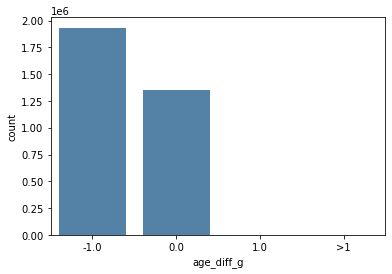

In [51]:
sns.countplot(x='age_diff_g', data=df_merge, color='steelblue') 

In [52]:
df_merge.groupby(by=['age_diff_g']).size()

age_diff_g
-1.0    1932056
0.0     1351023
1.0         477
>1         1979
dtype: int64

In [53]:
df_merge[df_merge['age_diff_g']==1].shape

(477, 12)

In [54]:
df_merge[df_merge['age_diff'] == 0].shape

(1351023, 12)

In [55]:
df_merge[df_merge['age_diff'] == -1].shape

(1932056, 12)

In [56]:
df_merge[df_merge['age_diff'] > 0].shape

(2456, 12)

In [57]:
df_merge[df_merge['age_diff'] != 0].shape

(1934512, 12)

In [58]:
df_to_update = df_merge[df_merge['age_diff'] == -1]
df_to_update['age'] = df_to_update.apply(lambda x: assign_not_null(x), axis=1)
df_to_update['age_diff'] == 0
df_merge.update(df_to_update)
df_to_update.head()

/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


uid    actitoid  birthday  birthmonth  \
0                                     NaN  22265988.0       NaN         NaN   
2563160  f67291714b9c4cd5b821a178c9f9839c  34121208.0       1.0         1.0   
1449363  7aaacc7f21434fdb9719987fa9b36c0c  25829471.0       1.0         1.0   
2563161  06b7e458179c4483a1090764c53bc840  34121232.0       1.0         1.0   
2563162  07a1b91e682f4417b2b73ae800716f5a  34121254.0       1.0         1.0   

         birthyear birthdate_actito  aprox_age assignedfirstname  \
0              NaN              NaN        NaN         Catherine   
2563160        NaN              NaN        NaN          Lancelot   
1449363        NaN              NaN        NaN             Jenna   
2563161        NaN              NaN        NaN           Olivier   
2563162        NaN              NaN        NaN           Josette   

             birthdate_gigya   age  age_diff age_diff_g  
0        1958-06-12 00:00:00  62.0      -1.0         -1  
2563160                  NaN   NaN      -1.0         -1  
1449363                  NaN   NaN      -1.0         -1  
2563161  1974-12-31 00:00:00  45.0      -1.0         -1  
2563162                  NaN   NaN      -1.0         -1

In [59]:
df_merge[df_merge['age_diff'] != 0].shape

(1934512, 12)

In [60]:
df_to_update = df_merge[df_merge['age_diff'] == 1]
df_to_update['age_diff'] = 0
df_merge.update(df_to_update)

/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
df_merge[df_merge['age_diff'] != 0].shape

(1934035, 12)

In [62]:
df_to_update = df_merge[(df_merge['age_diff'] > 50) & ((df_merge['age'] > 80) | (df_merge['aprox_age'] > 80))]
df_to_update['age'] = df_to_update.apply(lambda x: min(x['age'], x['aprox_age']), axis=1)
df_to_update['age_diff'] = 0
df_merge.update(df_to_update)

/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
df_merge[df_merge['age_diff'] != 0].shape

(1933960, 12)

In [64]:
df_to_update = df_merge[(df_merge['age_diff'] > 0) & ((df_merge['age'] < 10) | (df_merge['aprox_age'] < 10))]
df_to_update['age'] = df_to_update.apply(lambda x: max(x['age'], x['aprox_age']), axis=1)
df_to_update['age_diff'] = 0
df_merge.update(df_to_update)

/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
df_merge[df_merge['age_diff'] != 0].shape

(1933783, 12)

In [66]:
df_merge.count()

uid                  3172063
actitoid             3285535
birthday             3172063
birthmonth           3172063
birthyear            1410807
birthdate_actito     1410807
aprox_age            1410647
assignedfirstname    3285535
birthdate_gigya      1494384
age                  1550579
age_diff             3285535
age_diff_g           3285535
dtype: int64

In [67]:
export_df(df_merge, 'definition_publics')

In [46]:
df_merge.head()

uid    actitoid  birthday  birthmonth  \
0        0000de5ceabd4142a376fd1faa2d974f  39038563.0       1.0         1.0   
3216943  d9fad6bc16f64aa0aa6a32618219efa8  24510728.0       1.0         1.0   
1599641  860ea025ae094f328257e8c7d91b30ec  25111692.0       1.0         1.0   
1599640  860e93c401ac4150a5928fe4193fe19e  39688743.0       1.0         1.0   
1599639  860e8f7809c444a18b204d8d1e6874bd  39430234.0       1.0         1.0   

         birthyear birthdate_actito  aprox_age birthdate_gigya  age  age_diff  \
0              NaN              NaN        NaN             NaN  NaN      -1.0   
3216943        NaN              NaN        NaN             NaN  NaN      -1.0   
1599641        NaN              NaN        NaN             NaN  NaN      -1.0   
1599640        NaN              NaN        NaN             NaN  NaN      -1.0   
1599639        NaN              NaN        NaN             NaN  NaN      -1.0   

        age_diff_g  
0               -1  
3216943         -1  
1599641         -1  
1599640         -1  
1599639         -1

In [47]:
df_merge[df_merge['age'].isna()]

uid    actitoid  birthday  birthmonth  \
0        0000de5ceabd4142a376fd1faa2d974f  39038563.0       1.0         1.0   
3216943  d9fad6bc16f64aa0aa6a32618219efa8  24510728.0       1.0         1.0   
1599641  860ea025ae094f328257e8c7d91b30ec  25111692.0       1.0         1.0   
1599640  860e93c401ac4150a5928fe4193fe19e  39688743.0       1.0         1.0   
1599639  860e8f7809c444a18b204d8d1e6874bd  39430234.0       1.0         1.0   
...                                   ...         ...       ...         ...   
791241   46df2c9f507647388bc3e354a2afc892  38177098.0       1.0         1.0   
3470465  ffa0644f567e4186974a6d54593b4137  36480811.0       1.0         1.0   
3471427  ec5dccc34eba4cccb5500ddaf27e109e  27135104.0       1.0         1.0   
3471763  ecb6edf64c70410f8eab721d7d8f359c  27954545.0       1.0         1.0   
790882   467b4dadc2eb436c8ea9575451bc4cfb  28232009.0       1.0         1.0   

         birthyear birthdate_actito  aprox_age birthdate_gigya  age  age_diff  \
0              NaN              NaN        NaN             NaN  NaN      -1.0   
3216943        NaN              NaN        NaN             NaN  NaN      -1.0   
1599641        NaN              NaN        NaN             NaN  NaN      -1.0   
1599640        NaN              NaN        NaN             NaN  NaN      -1.0   
1599639        NaN              NaN        NaN             NaN  NaN      -1.0   
...            ...              ...        ...             ...  ...       ...   
791241         NaN              NaN        NaN             NaN  NaN      -1.0   
3470465        NaN              NaN        NaN             NaN  NaN      -1.0   
3471427        NaN              NaN        NaN             NaN  NaN      -1.0   
3471763        NaN              NaN        NaN             NaN  NaN      -1.0   
790882         NaN              NaN        NaN             NaN  NaN      -1.0   

        age_diff_g  
0               -1  
3216943         -1  
1599641         -1  
1599640         -1  
1599639         -1  
...            ...  
791241          -1  
3470465         -1  
3471427         -1  
3471763         -1  
790882          -1  

[2083930 rows x 11 columns]

In [49]:
df_fn = df_merge.merge(df_actito[['actitoid', 'assignedfirstname']], on='actitoid', how='left')

In [52]:
export_df(df_fn[~df_fn['age'].isna()][['actitoid','assignedfirstname','age']], 'fichier_validation')

In [53]:
df_fn[~df_fn['age'].isna()].shape

(1636402, 12)

In [ ]:
df_fn.hist()

In [45]:
df_merge['4-14'] = np.nan
df_merge['15-24'] = np.nan
df_merge['25-39'] = np.nan
df_merge['>35'] =  np.nan
df_to_update = df_merge[~(df_merge['age'].isna())]
df_to_update = df_to_update.apply(lambda x: set_public(x), axis=1)
df_merge.update(df_to_update)
df_merge[~df_merge['age'].isna()].head()


uid    actitoid  birthday  birthmonth  \
1529074  9561dcab9347477ca00b63a8d4855460  23845628.0      28.0        12.0   
3091592  d9fd183778284c7aa36141fb98e6e24b  25078502.0      17.0        12.0   
1528950  953ec98be779420f9c38883168947c8d  39658594.0      26.0        10.0   
1529000  954f0d6c79e14ac29c7da051975fa452  26182982.0       1.0         1.0   
1528985  954ab4338f1240dfad844f9fc344aa9b  25973458.0      24.0         8.0   

         birthyear     birthdate_actito  aprox_age      birthdate_gigya   age  \
1529074     1969.0  1969-12-28 00:00:00       50.0                  NaN  50.0   
3091592     1955.0  1955-12-17 00:00:00       64.0                  NaN  64.0   
1528950     1957.0  1957-10-26 00:00:00       62.0                  NaN  62.0   
1529000        NaN                  NaN        NaN  1966-03-02 00:00:00  54.0   
1528985     1950.0  1950-08-24 00:00:00       70.0                  NaN  70.0   

         age_diff age_diff_g  0-14  15-24  25-39  >35  
1529074      -1.0         -1   NaN    NaN    NaN  1.0  
3091592      -1.0         -1   NaN    NaN    NaN  1.0  
1528950      -1.0         -1   NaN    NaN    NaN  1.0  
1529000      -1.0         -1   NaN    NaN    NaN  1.0  
1528985      -1.0         -1   NaN    NaN    NaN  1.0

In [46]:
export_df(df_merge, 'definition_publics')

In [47]:
df_merge['age_range'] = df_merge['age'].apply(lambda x: set_age_range(x) if x == x else np.nan)
df_merge[~df_merge['age'].isna()].head(20)

uid    actitoid  birthday  birthmonth  \
1529074  9561dcab9347477ca00b63a8d4855460  23845628.0      28.0        12.0   
3091592  d9fd183778284c7aa36141fb98e6e24b  25078502.0      17.0        12.0   
1528950  953ec98be779420f9c38883168947c8d  39658594.0      26.0        10.0   
1529000  954f0d6c79e14ac29c7da051975fa452  26182982.0       1.0         1.0   
1528985  954ab4338f1240dfad844f9fc344aa9b  25973458.0      24.0         8.0   
3091515  d9ea055a06404a41930316bb87951d6b  26282671.0       1.0         9.0   
1529185  9588359528de40979cc19830dcff2d78  26374215.0       1.0         1.0   
1529235  9595299f8bf54270942c031fdc991898  39649966.0      16.0         9.0   
3091548  d9f28f8fd9274296977e6c6bb8254cc5  36832557.0      18.0         8.0   
1529096  956a727ca07c4e769faa59ef1287b255  25526881.0       1.0         1.0   
1529089  9568af0b759f4698bb58fc2d467181d0  39664662.0      16.0         7.0   
3091533  d9eefbc154024e6197a59d771703382b  39692278.0      12.0         8.0   
1529137  957a08f784664a7c8ad7016324f7d852  24588487.0       1.0         1.0   
1528721  9500f0669ab6462b94b7dfa2910c3e04  39710728.0      11.0         4.0   
3091671  da15f83dddbb453d8da7b02b788a3f3e  39682123.0       7.0         2.0   
1528766  950e08f6fbd04a3bb29dc7fb8800cd7c  24859965.0       1.0         1.0   
1528757  950b6474bcec4a52880e51e67d48ac14  24348840.0      13.0         4.0   
3091674  da168e67329746ea99d5ba23ae91a1a5  24618805.0       1.0         1.0   
1528698  94fafb43cb6f49f39d0501e8b9032923  28292276.0       5.0         3.0   
1528690  94f8bf1b0c684e7ba679175156081a1a  25111754.0       1.0         1.0   

         birthyear     birthdate_actito  aprox_age      birthdate_gigya   age  \
1529074     1969.0  1969-12-28 00:00:00       50.0                  NaN  50.0   
3091592     1955.0  1955-12-17 00:00:00       64.0                  NaN  64.0   
1528950     1957.0  1957-10-26 00:00:00       62.0                  NaN  62.0   
1529000        NaN                  NaN        NaN  1966-03-02 00:00:00  54.0   
1528985     1950.0  1950-08-24 00:00:00       70.0                  NaN  70.0   
3091515     1947.0  1947-09-01 00:00:00       73.0                  NaN  73.0   
1529185        NaN                  NaN        NaN  2000-01-14 00:00:00  20.0   
1529235     1970.0  1970-09-16 00:00:00       49.0                  NaN  49.0   
3091548     1982.0  1982-08-18 00:00:00       38.0                  NaN  38.0   
1529096        NaN                  NaN        NaN  1982-06-02 00:00:00  38.0   
1529089     1964.0  1964-07-16 00:00:00       56.0                  NaN  56.0   
3091533     2000.0  2000-08-12 00:00:00       20.0                  NaN  20.0   
1529137     1970.0  1970-01-01 00:00:00       50.0                  NaN  50.0   
1528721     1977.0  1977-04-11 00:00:00       43.0                  NaN  43.0   
3091671     1999.0  1999-02-07 00:00:00       21.0                  NaN  21.0   
1528766     1985.0  1985-01-01 00:00:00       35.0                  NaN  35.0   
1528757     1968.0  1968-04-13 00:00:00       52.0                  NaN  52.0   
3091674        NaN                  NaN        NaN  1972-11-26 00:00:00  47.0   
1528698     1975.0  1975-03-05 00:00:00       45.0                  NaN  45.0   
1528690        NaN                  NaN        NaN  1992-08-01 00:00:00  28.0   

         age_diff age_diff_g  0-14  15-24  25-39  >35 age_range  
1529074      -1.0         -1   NaN    NaN    NaN  1.0     45-54  
3091592      -1.0         -1   NaN    NaN    NaN  1.0     55-64  
1528950      -1.0         -1   NaN    NaN    NaN  1.0     55-64  
1529000      -1.0         -1   NaN    NaN    NaN  1.0     45-54  
1528985      -1.0         -1   NaN    NaN    NaN  1.0       65+  
3091515      -1.0         -1   NaN    NaN    NaN  1.0       65+  
1529185      -1.0         -1   NaN    1.0    NaN  NaN     15-24  
1529235      -1.0         -1   NaN    NaN    NaN  1.0     45-54  
3091548      -1.0         -1   NaN    NaN    1.0  1.0     35-44  
1529096      -1.

In [ ]:
df_merge()

In [48]:
export_df(df_merge, 'definition_publics')

In [49]:
df_merge.count()

uid                 3569080
actitoid            3563785
birthday            3569080
birthmonth          3569080
birthyear           1536713
birthdate_actito    1536713
aprox_age           1536401
birthdate_gigya     1507560
age                 1594781
age_diff            3569080
age_diff_g          3569080
0-14                   5054
15-24                231708
25-39                511455
>35                  996723
age_range           1594781
dtype: int64

In [50]:
df_merge.shape

(3569080, 16)

In [55]:
df_merge[['uid', 'age', '4-14', '15-24', '25-39', '>35', 'age_range']].to_csv('output/{}_definition_publiques.csv'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')), index=False, encoding='utf-8-sig')

In [7]:
publics = ['4-14', '15-24', '25-39']

In [8]:
pd.unique(df_merge[['4-14', '15-24', '25-39', '>35', 'age_range']].values.ravel('K'))

array([nan, 1.0, '45-54', '55-64', '65+', '15-24', '35-44', '25-34',
       '5-14', '4-13'], dtype=object)

In [10]:
df_merge['public'] = df_merge.apply(lambda x: ''.join([pub for pub in publics if x[pub] == x[pub]]), axis=1)

In [11]:
df_merge['>35'] = df_merge['>35'].apply(lambda x: x if x == x else 0)

In [12]:
export_df(df_merge[['uid', '>35', 'age_range', 'public']], 'egos_gigya_augmented')

In [7]:
df_gigya_genre = pd.read_csv('output/201013_uid_ass_gender.csv')
df_gigya_genre.head()

email  \
0     scorpion2918@hotmail.com   
1    suzyvercammen@hotmail.com   
2    gignoux.florian@orange.fr   
3         tisouri97@hotmail.fr   
4  chantal.rozenberg@gmail.com   

                                                 uid assigned_gender  
0  _guid_Cw5KoREimFlcYln6432EFGQ--Y0NgrGS8h_QkCek...             NaN  
1  _guid_n0anDf0XRKUXBd1buLYMqWz1A0akj5oMqRs5XG74...               f  
2                   d9da9bf375814962961a0294461dedb1               f  
3                   8abca84e58aa463f9db1a91db47f368b               m  
4  _guid_DSGUlnLE8fsKtkL-Blt9mu-KEPYDB12BvR17_KUt...               f

In [11]:
df_gigya_aug = pd.read_csv('output/200911_definition_publics.csv')
df_gigya_aug.head()

uid    actitoid  birthday  birthmonth  \
0  0000178f7271412ba791e5498feebd65  26129508.0      22.0         8.0   
1  00002be0ffb444c79aaabc29aa285b4f  25746247.0      27.0         7.0   
2  00006466d69648c4ac51b520e7b0819f  27070704.0      22.0         9.0   
3  0001fc6491e64f319f91a403b13d0880  26164211.0      29.0         1.0   
4  0002165c65ba49baa47ded934a6e76a2  39505945.0       4.0         8.0   

   birthyear     birthdate_actito  aprox_age      birthdate_gigya   age  \
0     1975.0  1975-08-22 00:00:00       45.0  1975-08-22 00:00:00  45.0   
1     1988.0  1988-07-27 00:00:00       32.0  1988-07-27 00:00:00  32.0   
2     1968.0  1968-09-22 00:00:00       52.0                  NaN   NaN   
3     2004.0  2004-01-29 00:00:00       16.0  2004-01-29 00:00:00  16.0   
4     2003.0  2003-08-04 00:00:00       17.0  2003-08-04 00:00:00  17.0   

   age_diff  
0       0.0  
1       0.0  
2      -1.0  
3       0.0  
4       0.0

In [14]:
len(df_gigya_aug['age'].unique())

3648213

In [15]:
df_gigya_aug.count()

uid                 3648213
actitoid            3642373
birthday            3648213
birthmonth          3648213
birthyear           1561942
birthdate_actito    1561942
aprox_age           1561521
birthdate_gigya     1536648
age                 1536180
age_diff            3648213
dtype: int64

In [12]:
df_gigya_aug.columns

Index(['uid', 'actitoid', 'birthday', 'birthmonth', 'birthyear',
       'birthdate_actito', 'aprox_age', 'birthdate_gigya', 'age', 'age_diff'],
      dtype='object')

In [16]:
df_gigya_aug = df_gigya_aug.merge(df_gigya_genre[['uid', 'assignedgender']], on='uid', how='left').rename(columns={'assignedgender': 'gender'})
df_gigya_aug.head()

uid  >35 age_range public  \
0  _guid_CS4vFSKzwMfBLvF9fXX9FW_MTdoQxoAvPwlF1oLa...  0.0       NaN    NaN   
1                   d9f727cc8f91444790ca9c4f318a9159  0.0       NaN    NaN   
2                   955927d6eb2d49ae8cad8e50c3c93652  0.0       NaN    NaN   
3                   9558daa7798745de9f493a873eeba947  0.0       NaN    NaN   
4                   95583e8b32984175bce3a0aee3c1c0e7  0.0       NaN    NaN   

  gender  
0    NaN  
1      m  
2      f  
3    NaN  
4      m

In [17]:
export_df(df_gigya_aug, 'egos_gigya_augmented')

In [18]:
df_gigya_aug[~df_gigya_aug['gender'].isna()]

uid  >35 age_range  \
1                         d9f727cc8f91444790ca9c4f318a9159  0.0       NaN   
2                         955927d6eb2d49ae8cad8e50c3c93652  0.0       NaN   
4                         95583e8b32984175bce3a0aee3c1c0e7  0.0       NaN   
6                         d9f845e53c4c4660b9b24a2164f5021a  0.0       NaN   
7                         d9f882b3d1464e0ea791b89378559ded  0.0       NaN   
...                                                    ...  ...       ...   
3569075                   13f377ec7f364513b092c4243fae6b35  0.0     15-24   
3569076  _guid_3pEM5-9NZhSlQlH3Ldnj3So-aLNsaD7VHrVUr80M...  0.0     15-24   
3569077                   2c20c874faa240c69accaace54ab95b2  0.0      4-14   
3569078                   1ac8af0d032a405ab581921225b988c7  0.0      4-14   
3569079  _guid_Mjz6Cuv6u2qK800cQAeilVodxpZ5RkIqkbxGH_F7...  0.0      4-14   

        public gender  
1          NaN      m  
2          NaN      f  
4          NaN      m  
6          NaN      m  
7          NaN      m  
...        ...    ...  
3569075  15-24      m  
3569076  15-24      m  
3569077   4-14      f  
3569078   4-14      m  
3569079   4-14      f  

[2849531 rows x 5 columns]

In [19]:
df_gigya_aug[~df_gigya_aug['age_range'].isna()]

uid  >35 age_range  \
43                        9561dcab9347477ca00b63a8d4855460  1.0     45-54   
70                        d9fd183778284c7aa36141fb98e6e24b  1.0     55-64   
92                        953ec98be779420f9c38883168947c8d  1.0     55-64   
111                       954f0d6c79e14ac29c7da051975fa452  1.0     45-54   
126                       954ab4338f1240dfad844f9fc344aa9b  1.0       65+   
...                                                    ...  ...       ...   
3569075                   13f377ec7f364513b092c4243fae6b35  0.0     15-24   
3569076  _guid_3pEM5-9NZhSlQlH3Ldnj3So-aLNsaD7VHrVUr80M...  0.0     15-24   
3569077                   2c20c874faa240c69accaace54ab95b2  0.0      4-14   
3569078                   1ac8af0d032a405ab581921225b988c7  0.0      4-14   
3569079  _guid_Mjz6Cuv6u2qK800cQAeilVodxpZ5RkIqkbxGH_F7...  0.0      4-14   

        public gender  
43         NaN      m  
70         NaN      m  
92         NaN      m  
111        NaN      f  
126        NaN      f  
...        ...    ...  
3569075  15-24      m  
3569076  15-24      m  
3569077   4-14      f  
3569078   4-14      m  
3569079   4-14      f  

[1594781 rows x 5 columns]

In [22]:
pd.read_sql_query("""select distinct gender, count(*) from egos_actito group by gender""", engine)

gender    count
0      F   975873
1         1202180
2      M  1388218

# Export pour Baptiste Daudet
### Publications : pilotage par les données - 08/09 
### 10/09/2020
Hello Meili,

Merci pour ton mail,

Penses-tu que tu pourrais m’envoyer, sur base du travail déjà présenté à Pierre et moi la fois dernière (sur les résultats par âge et genre), quelques insights qui seraient utiles pour com ?

L’idée serait d’avoir à date le nombre d’utilisateurs inscrits, et parmi eux la répartition par genre et par âge (selon les tranches 4-14 / 15-24 / 25-34 / 45-54 /  55-64 / 65+) et par public (4-14 / 15-24 / 25-39 / 35+).

Penses-tu qu’il serait possible d’avoir le nombre d’utilisateurs inscrits par mois depuis décembre 2016 ?

Et enfin, crois-tu qu’il serait envisageable d’avoir le nombre d’utilisateurs connectés par jour ou par mois depuis cette même date ?

Afin de pouvoir objectiver et valoriser les résultats intéressants :)

Merci beaucoup déjà et à très vite,

Baptiste

In [13]:
df_publics = pd.read_csv('output/200911_egos_gigya_augmented.csv')
df_publics.head()

uid  >35 age_range public
0  _guid_CS4vFSKzwMfBLvF9fXX9FW_MTdoQxoAvPwlF1oLa...  0.0       NaN    NaN
1                   d9f727cc8f91444790ca9c4f318a9159  0.0       NaN    NaN
2                   955927d6eb2d49ae8cad8e50c3c93652  0.0       NaN    NaN
3                   9558daa7798745de9f493a873eeba947  0.0       NaN    NaN
4                   95583e8b32984175bce3a0aee3c1c0e7  0.0       NaN    NaN

---
L’idée serait d’avoir à date le nombre d’utilisateurs inscrits

In [14]:
df_count = pd.read_sql_query("""SELECT COUNT(*) FROM egos_gigya""", engine)
df_count

count
0  3569080

---
et parmi eux la répartition par genre

In [150]:
df_gigya = pd.read_sql_query("""SELECT uid FROM egos_gigya""", engine)
df_gigya.head()

uid
0  0000178f7271412ba791e5498feebd65
1  00002be0ffb444c79aaabc29aa285b4f
2  00006466d69648c4ac51b520e7b0819f
3  0001fc6491e64f319f91a403b13d0880
4  0002165c65ba49baa47ded934a6e76a2

In [151]:
df_gigya.shape

(3586198, 1)

In [160]:
df_augmented = pd.read_csv('input/200915_gigya_attribution_firstname.csv')
df_augmented.shape

(2983028, 4)

In [158]:
df_gender = df_augmented.groupby('assignedgender').size().reset_index()
df_gender

assignedgender        0
0              f  1281310
1              m  1575572

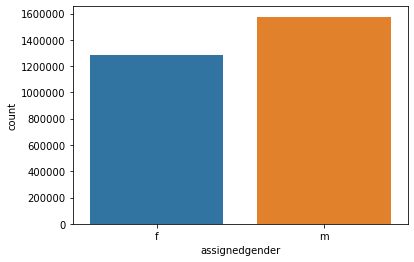

In [159]:
sns.countplot(x='assignedgender', data=df_augmented)

---
et par âge (selon les tranches 4-14 / 15-24 / 25-34 / 45-54 / 55-64 / 65+)

In [19]:
df_publics[~df_publics['age_range'].isna()].shape

(1594781, 4)

In [61]:
df_publics['age_range'] = df_publics['age_range'].apply(lambda x: '5-14' if x == '4-13' else x)
df_publics['temp'] = df_publics['age_range'].apply(lambda x: int(x.split('-')[0]) if x == x and x != '65+' else 65 if x == '65+' else x)

In [62]:
df_publics = df_publics.sort_values('temp')

In [67]:
df_age_ranges = df_publics.groupby(['temp','age_range']).size().reset_index().rename(columns={0:'count'})
df_age_ranges = df_age_ranges.sort_values('temp')[['age_range', 'count']]
records = np.sum(df_age_ranges['count'])
df_age_ranges['percentage'] = df_age_ranges['count'].apply(lambda x: round(x/records, 2))
df_age_ranges

age_range   count  percentage
0      5-14    5054        0.00
1     15-24  231708        0.15
2     25-34  361296        0.23
3     35-44  294237        0.18
4     45-54  276253        0.17
5     55-64  227823        0.14
6       65+  198410        0.12

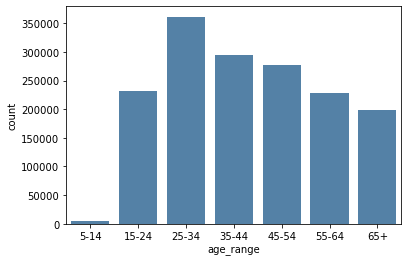

In [63]:
sns.countplot(x='age_range', data=df_publics, color='steelblue')

---
et par public (4-14 / 15-24 / 25-39 / 35+).

In [20]:
df_publics[~(df_publics['public'].isna()) | (df_publics['>35'] == 1)].shape

(1594781, 4)

In [23]:
df_publics['public'].unique()

array([nan, '15-24', '25-39', '4-14'], dtype=object)

In [44]:
publics = df_publics.groupby('public').size().reset_index().rename(columns={0:'count'})
publics = publics.to_dict('records')
publics

[{'public': '15-24', 'count': 231708},
 {'public': '25-39', 'count': 511455},
 {'public': '4-14', 'count': 5054}]

In [45]:
publics.append({'public': '>35', 'count': df_publics[df_publics['>35'] == 1].shape[0]})
publics

[{'public': '15-24', 'count': 231708},
 {'public': '25-39', 'count': 511455},
 {'public': '4-14', 'count': 5054},
 {'public': '>35', 'count': 996723}]

In [65]:
df_publics_count = pd.DataFrame(publics)
df_publics_count

public   count
2   4-14    5054
0  15-24  231708
1  25-39  511455
3    >35  996723

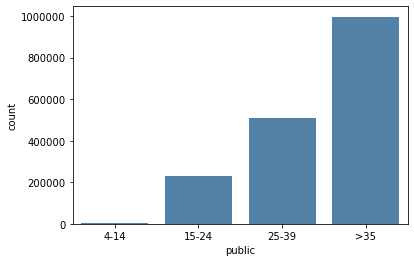

In [51]:
sns.barplot(x='public', y='count', data=df_publics_count, color='steelblue')

---
Penses-tu qu’il serait possible d’avoir le nombre d’utilisateurs inscrits par mois depuis décembre 2016 ?

In [12]:
df_gigya_all = pd.read_sql_query("""SELECT uid, created FROM egos_gigya WHERE created > '2016-12-01'""", engine)
df_gigya_all.head()

uid                 created
0  00004bc429c74f72843ecb4938ad8005 2019-02-04 19:37:54.132
1  0000b7d2e4ed43eeaaf362589a25057b 2018-11-13 07:59:47.042
2  00013e4f4736435ab19025635319a6b9 2020-03-10 06:43:03.908
3  000171db2bcb47089a60614fae200bf0 2019-02-07 09:30:51.337
4  000178ee848f42058ee7e092aa34b708 2018-07-10 09:07:24.468

In [135]:
df_gigya_all['month'] = df_gigya_all['created'].apply(lambda x: datetime.datetime(x.year, x.month, 1))

In [136]:
df_created = df_gigya_all[['month']].groupby('month').size().reset_index().rename(columns={'month': 'date', 0: 'created_users'})

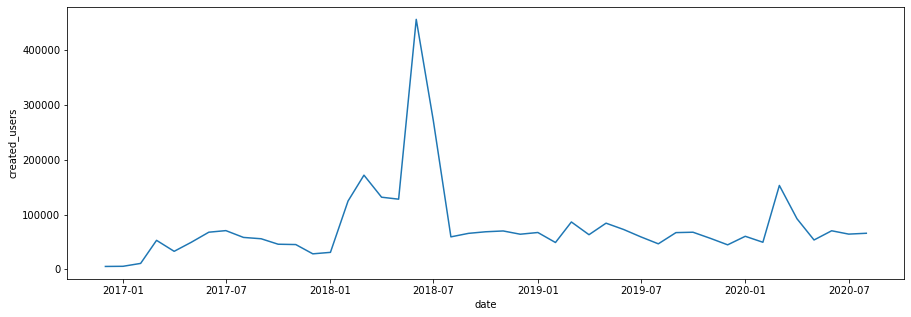

In [153]:
plt.figure(figsize = (15,5))
sns.lineplot(x='date', y='created_users', data=df_created[df_created['date'] < datetime.datetime(2020,9,1)])
plt.show()

In [29]:
export_df(df_created, 'users_created_per_month')

---
Et enfin, crois-tu qu’il serait envisageable d’avoir le nombre d’utilisateurs connectés par jour ou par mois depuis cette même date ?

In [55]:
df_metrics = pd.read_sql_query("""SELECT * FROM egos_accounts_metrics""", engine)
df_metrics.head()

month  created_accounts  total_accounts  active_accounts
0  2016-12-01              5140            5140              NaN
1  2017-12-01             28165          527137         104959.0
2  2018-12-01             63991         2169363         423933.0
3  2019-12-01             44616         2932770         409364.0
4  2017-02-01             10693           21234              NaN

In [85]:
values = []
for i in range(1,12):
    val = '{}'.format(1)
    if len(val) == 1:
        val = '0{}'.format(val)
    values.append(val)
print(val)

01


In [7]:
df_connected_users = pd.DataFrame(columns=['month', 'year', 'connected_users'])

In [8]:
for i in range(2017, 2021):
    df_tmp = pd.read_sql_query("""SELECT EXTRACT('month' FROM convert_timezone('Europe/Brussels', t.timestamp_iso)) AS month, '{}' AS year, COUNT(DISTINCT t.data.user.uid) AS connected_users FROM bda_spectrum_poc.parquet as t WHERE t.partition_3 = 'track' AND octet_length(t.data.user.uid) != '36' AND octet_length(t.data.user.uid) < 51 AND t.data.user.uid != 'Private' AND t.data.user.uid != 'anonymous' AND t.partition_0 = '{}' GROUP BY month""".format(i, i), engine)
    df_tmp = df_tmp.sort_values(by='month')
    df_connected_users = pd.concat([df_connected_users, df_tmp], ignore_index=True)
    print(i, df_connected_users.shape)
df_connected_users.shape

2017 (12, 3)
2018 (24, 3)
2019 (36, 3)
2020 (45, 3)


(45, 3)

In [9]:
df_connected_users['month'] = df_connected_users['month'].astype(int)
df_connected_users['year'] = df_connected_users['year'].astype(int)
df_connected_users['connected_users'] = df_connected_users['connected_users'].astype(int)

In [10]:
df_connected_users['date'] = df_connected_users.apply(lambda x: datetime.datetime(x['year'], x['month'], 1), axis=1)
df_connected_users.head()

month  year  connected_users       date
0      1  2017             7079 2017-01-01
1      2  2017            12339 2017-02-01
2      3  2017            57482 2017-03-01
3      4  2017            64385 2017-04-01
4      5  2017            94677 2017-05-01

In [11]:
df_connected_users.tail()

month  year  connected_users       date
40      5  2020           813883 2020-05-01
41      6  2020           768612 2020-06-01
42      7  2020           785577 2020-07-01
43      8  2020           807658 2020-08-01
44      9  2020           452421 2020-09-01

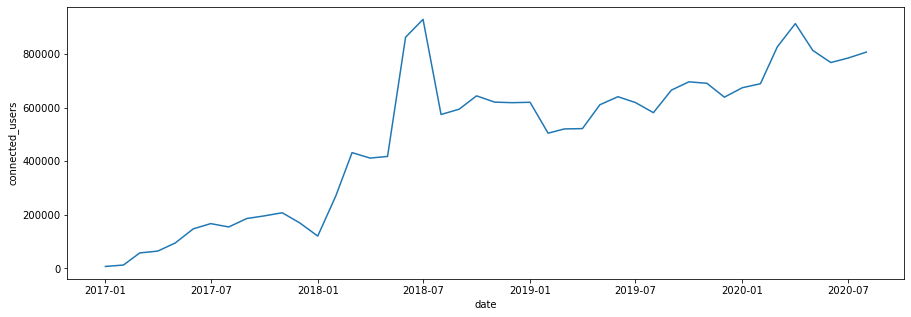

In [12]:
plt.figure(figsize = (15,5))
sns.lineplot(x='date', y='connected_users', data=df_connected_users[df_connected_users['date'] < datetime.datetime(2020,9,1)])
plt.show()

In [143]:
df_metrics = pd.merge(left=df_created, right=df_connected_users[['date', 'connected_users']], on='date', how='left')
df_metrics['month'] = df_metrics['date'].dt.month
df_metrics['year'] = df_metrics['date'].dt.year
df_metrics = df_metrics[['year', 'month', 'created_users', 'connected_users']]
df_metrics.head()

year  month  created_users  connected_users
0  2016     12           5140              NaN
1  2017      1           5402           7081.0
2  2017      2          10694          12341.0
3  2017      3          52818          57483.0
4  2017      4          32757          64386.0

In [144]:
export_df(df_metrics, 'monthly_users_report')

# Consumtion counts

In [30]:
where = """t.partition_0 = '{}' AND EXTRACT('week' FROM convert_timezone('Europe/Brussels', t.timestamp_iso)) = '{}'""".format(2020,37)
df_cons = pd.read_sql_query("""SELECT COUNT(t.data.user.uid) AS connected_users, t.data.context.screen.media.type as type FROM bda_spectrum_poc.parquet as t WHERE t.partition_3 = 'track' AND octet_length(t.data.user.uid) != '36' AND octet_length(t.data.user.uid) < 51 AND t.data.user.uid != 'Private' AND t.data.user.uid != 'anonymous' AND t.partition_0 = '2020' AND t.data.action = 'LOAD' AND {} GROUP BY t.data.context.screen.media.type""".format(where), engine)
df_cons.head()

connected_users     type
0          3759690     None
1           802012  article
2           691592     live
3            15508    audio
4          1119453    video

In [38]:
count_obj = {}
for i,row in df_cons.iterrows():
    if row['type'] is not None:
        count_obj[row['type']] = row['connected_users']

In [39]:
count_obj

{'article': 802012, 'live': 691592, 'audio': 15508, 'video': 1119453}

# TEMP

In [55]:
time_range = """WHERE EXTRACT(year FROM date) = EXTRACT(year FROM CURRENT_DATE) AND EXTRACT(week FROM date) = (EXTRACT(week FROM CURRENT_DATE)-1)"""
query = """SELECT * FROM (SELECT conso.uid, CAST(conso.article_id AS VARCHAR) AS media_id, 'article' as type, article.title, article.feed AS group FROM egos_conso_article_connected_user conso INNER JOIN article_article article ON conso.article_id = article.id {}) UNION ALL (SELECT conso.uid, CAST(conso.media_id AS VARCHAR), conso.media_type as type, media.title, media.group FROM egos_conso_audio_video_connected_user conso INNER JOIN (SELECT mo.id, mp.labelstat AS title, mo.provider AS group FROM media_objects mo INNER JOIN media_programs mp ON mo.program_id = mp.id) media ON conso.media_id = media.id {})""".format(time_range, time_range)
df = pd.read_sql_query(query, engine)

In [18]:
types = df['type'].unique()
top_media = {}
for typ in types:
    top_media[typ] = list(df[df['type'] == typ].groupby(
        'media_id').size().reset_index().sort_values(by=0, ascending=False).head(10)['media_id'])


In [16]:
gigya_aug = pd.read_csv('output/200820_egos_gigya_augmented.csv')
gigya_aug.head()

uid  >35 age_range gender public
0    _guid_SA5ddoNKuUj0vhFLuOEabA==  1.0     55-64      f    NaN
1  18b078a26c68469a901bd6b71d9384be  1.0     35-44      m  25-39
2  803f0f67f57749cab1c4a1d39dac7e93  1.0     55-64      f    NaN
3  3f592aa44ad3415aaac7950f02ed7622  0.0       NaN      f    NaN
4  2db49b0a1fbd4f48a2da7199539de078  0.0       NaN    NaN    NaN

In [17]:
df = df.merge(gigya_aug, on='uid', how='left')

In [33]:
top_medias = []
[top_medias.extend(l) for l in top_media.values()]
top_medias

['2668746',
 '2669449',
 '2669919',
 '2670307',
 '2669430',
 '2670875',
 '2669440',
 '2669896',
 '2670299',
 '2668849',
 '2671426',
 '2669283',
 '2671181',
 '2671190',
 '2671068',
 '2670100',
 '2670823',
 '2669698',
 '2669635',
 '2670482',
 '2670731',
 '2659797',
 '2670875']

In [20]:
df.head()

uid media_id   type  title  \
0  _guid_EmwUn-huM1JJz0ps6oAn44ITDkjoZTA3hk7n0ehJ...  1635223  video  DALET   
1  _guid_xcg6arKL3eW0EdxeWgUuuPVpIhSgzBr40Y42v-MQ...  1831578  video  DALET   
2  _guid_xcg6arKL3eW0EdxeWgUuuPVpIhSgzBr40Y42v-MQ...  1831578  video  DALET   
3  _guid_xcg6arKL3eW0EdxeWgUuuPVpIhSgzBr40Y42v-MQ...  1831578  video  DALET   
4  _guid_xcg6arKL3eW0EdxeWgUuuPVpIhSgzBr40Y42v-MQ...  1831578  video  DALET   

       group  >35 age_range gender public  
0   Football  NaN       NaN    NaN    NaN  
1  Le cactus  0.0       NaN      m    NaN  
2  Le cactus  0.0       NaN      m    NaN  
3  Le cactus  0.0       NaN      m    NaN  
4  Le cactus  0.0       NaN      m    NaN

In [21]:
age_range = df.groupby(
            by=['media_id', 'type', 'title', 'group', 'age_range']).size().reset_index().rename(columns={0: 'users'})
age_range.head()

media_id   type  title                 group age_range  users
0  1036423  video   CRYO  JT - Sujet par sujet     45-54      1
1  1067853  video  DALET                  info     45-54     13
2  1100243  video   CRYO  JT - Sujet par sujet     35-44    164
3  1142683  video   CRYO  JT - Sujet par sujet     35-44    164
4  1161633  video  DALET                  info     65-74      4

In [41]:
def get_pyramid_values(df, groups, classifier):
    g1 = groups.copy()
    g1.extend([classifier, 'gender'])
    df_group = df.groupby(by=g1).size().reset_index()

    g2 = groups.copy()
    g2.extend([classifier, 0])
    df_group_f = df_group[df_group['gender']
                          == 'f'][g2].rename(columns={0: 'f'})

    df_group_m = df_group[df_group['gender']
                          == 'm'][g2].rename(columns={0: 'm'})

    g3 = groups.copy()
    g3.append(classifier)
    df_group = pd.merge(left=df_group_f, right=df_group_m, on=g3)

    columns = df_group.columns

    df_group['temp'] = df_group[classifier]
    df_group['temp'] = df_group['temp'].apply(lambda x: x.split('-')[0] if '-' in x else x)
    print(df_group['temp'])
#    df_group['temp'] = df_group['temp'].apply(lambda x: int(x))

    df_group = df_group.sort_values(by='temp')

    return df_group[columns]

In [30]:
public = get_pyramid_values(df, ['type'], 'public')
public.head()

type public      f      m
0  audio   0-14      4      8
3  video   0-14   5369   2803
1  audio  15-24    104   1321
4  video  15-24  82823  77509
2  audio  25-39   2418   7760

In [42]:
get_pyramid_values(df[df['media_id'].isin(top_medias)], ['media_id', 'type', 'title', 'group'], 'age_range')

0       25
1       35
2       45
3       55
4      115
      ... 
180     45
181     55
182     65
183     75
184     55
Name: temp, Length: 185, dtype: object


media_id   type    title                   group age_range   f    m
15   2668849  video  WHATSON             Films Prime      -5-4   8   37
45   2669440  video  WHATSON       Plus Belle la vie   105-114  10   20
35   2669430  video  WHATSON       Plus Belle la vie   105-114   5   10
81   2669896  video  WHATSON       Plus Belle la vie   105-114   5   10
91   2669919  video  WHATSON  Demain nous appartient   105-114   3   17
..       ...    ...      ...                     ...       ...  ..  ...
54   2669440  video  WHATSON       Plus Belle la vie    95-104  80  106
102  2669919  video  WHATSON  Demain nous appartient    95-104  77   40
131  2670307  video  WHATSON  Demain nous appartient    95-104  84   77
44   2669430  video  WHATSON       Plus Belle la vie    95-104  88   86
164  2670875  video  WHATSON  Demain nous appartient    95-104  63   29

[185 rows x 7 columns]

In [39]:
import re

In [43]:
get_pyramid_values(df[(df['media_id'].isin(top_medias)) & (~df['age_range'].isna())], [
            'media_id', 'type', 'title', 'group'], 'age_range').to_dict('records')

0       25
1       35
2       45
3       55
4      115
      ... 
180     45
181     55
182     65
183     75
184     55
Name: temp, Length: 185, dtype: object


[{'media_id': '2668849',
  'type': 'video',
  'title': 'WHATSON',
  'group': 'Films Prime',
  'age_range': '-5-4',
  'f': 8,
  'm': 37},
 {'media_id': '2669440',
  'type': 'video',
  'title': 'WHATSON',
  'group': 'Plus Belle la vie',
  'age_range': '105-114',
  'f': 10,
  'm': 20},
 {'media_id': '2669430',
  'type': 'video',
  'title': 'WHATSON',
  'group': 'Plus Belle la vie',
  'age_range': '105-114',
  'f': 5,
  'm': 10},
 {'media_id': '2669896',
  'type': 'video',
  'title': 'WHATSON',
  'group': 'Plus Belle la vie',
  'age_range': '105-114',
  'f': 5,
  'm': 10},
 {'media_id': '2669919',
  'type': 'video',
  'title': 'WHATSON',
  'group': 'Demain nous appartient',
  'age_range': '105-114',
  'f': 3,
  'm': 17},
 {'media_id': '2670299',
  'type': 'video',
  'title': 'WHATSON',
  'group': 'Plus Belle la vie',
  'age_range': '105-114',
  'f': 5,
  'm': 10},
 {'media_id': '2668849',
  'type': 'video',
  'title': 'WHATSON',
  'group': 'Films Prime',
  'age_range': '105-114',
  'f': 5,

In [48]:
gigya_aug['age_range']

0         55-64
1         35-44
2         55-64
3           NaN
4           NaN
          ...  
890490      NaN
890491    55-64
890492    45-54
890493    25-34
890494    15-24
Name: age_range, Length: 890495, dtype: object

In [49]:
#to_up = 
gigya_aug[gigya_aug['age_range'] == '-5-4']
#to_up['age_range'] = '0-4'
#gigya_aug.update(to_up)

Empty DataFrame
Columns: [uid, >35, age_range, gender, public]
Index: []

In [50]:
export_df(gigya_aug, 'egos_gigya_augmented')

In [56]:
list(df['title'].unique())

['Un Gars un Chef',
 'Plus de sports',
 'RTBF Auvio',
 'La vie du bon côté',
 'Coupe de Belgique',
 'Burkland',
 'Matière Grise',
 'Les Décodeurs RTBF',
 'Pure Sessions',
 'Melting Pot café',
 'Matin Première - Invité',
 'Luxembourg Matin',
 'Le Gala du Voo Rire',
 'Jeux Paralympiques',
 'Coupe du Monde Football - Archives',
 'Complètement Foot',
 'Info pour la presse',
 'C est presque sérieux',
 'Diables Rouges',
 'Matin Première - Café Serré',
 'Pure Videocast',
 'Le grand cactus',
 'Snooze',
 'Feuilleton Bernard Lavilliers',
 '1000 jours dans l Histoire',
 'La stagiaire',
 'Devoir d Enquête',
 'JT - Sujet par sujet',
 'On n est pas des pigeons',
 'Game of Thrones',
 'Europa League',
 'Protest Song',
 'Le 6-8',
 'C est du Belge',
 'Les enfants de choeur',
 'Et Dieu dans tout ça',
 'Auto Mobile',
 'Pop and Snob',
 'Le Grand Show des Animateurs',
 'La Belgique criminelle',
 'info',
 'Jeudi en prime',
 'Euh',
 'Tendances Première',
 'Empreinte digitale',
 'Le Scan',
 'Jardins et Loisirs

In [53]:
df = pd.read_sql_query("""SELECT mo.id, mp.labelstat, mo.provider FROM media_objects mo INNER JOIN media_programs mp ON mo.program_id = mp.id""", engine)
df.head()

id             labelstat     provider
0  2499685       Bandes-annonces        OTHER
1  2309042              Le drive  CHAPTERAUTO
2  2220152                Tennis         CRYO
3  2363937  JT - Sujet par sujet        AREMA
4  2484310                  RTBF   LIVECENTER

In [54]:
df[df['labelstat'] == 'CRYO']

Empty DataFrame
Columns: [id, labelstat, provider]
Index: []

In [66]:
conso_top_media = df[df['media_id'].isin(top_medias)].groupby(by=['title']).size().reset_index().rename(columns={0: 'users'}).set_index('title')
conso_top_media

users
title                                            
5 heures du Soir                              851
Bulle sports - dimanche                       684
Completement Foot Podcast                     336
Cyclisme                                      301
Demain nous appartient                      76114
Et pourquoi                                    80
Films Prime                                 11040
Histoire criminelle enquetes Scotland Yard    395
La stagiaire                                 2288
Plus Belle la vie                           41405
info                                          852

In [68]:
conso_top_media.T.to_dict('index')

{'users': {'5 heures du Soir': 851,
  'Bulle sports - dimanche': 684,
  'Completement Foot Podcast': 336,
  'Cyclisme': 301,
  'Demain nous appartient': 76114,
  'Et pourquoi': 80,
  'Films Prime': 11040,
  'Histoire criminelle enquetes Scotland Yard': 395,
  'La stagiaire': 2288,
  'Plus Belle la vie': 41405,
  'info': 852}}

In [51]:
df[df['type'] == 'article'].shape

NameError: name 'df' is not defined